Mounted at /content/gdrive
Found 20111 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Training set has 10094 cat images and 10017 dog images.
Validation set has 400 cat images and 400 dog images.
Test set has 150 cat images and 150 dog images.
Epoch 1/150
628/628 [==============================] - 588s 880ms/step - loss: 0.7904 - accuracy: 0.5904 - val_loss: 0.7636 - val_accuracy: 0.6363
Epoch 2/150
628/628 [==============================] - 546s 869ms/step - loss: 0.6204 - accuracy: 0.6572 - val_loss: 0.8320 - val_accuracy: 0.6338
Epoch 3/150
628/628 [==============================] - 547s 871ms/step - loss: 0.5729 - accuracy: 0.6975 - val_loss: 0.6397 - val_accuracy: 0.6888
Epoch 4/150
628/628 [==============================] - 546s 870ms/step - loss: 0.5437 - accuracy: 0.7267 - val_loss: 0.7454 - val_accuracy: 0.6062
Epoch 5/150
628/628 [==============================] - 545s 868ms/step - loss: 0.5040 - accuracy: 0.75

<ipython-input-1-e3748baa0723>:179: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_generator,


Test Accuracy -> 97.667


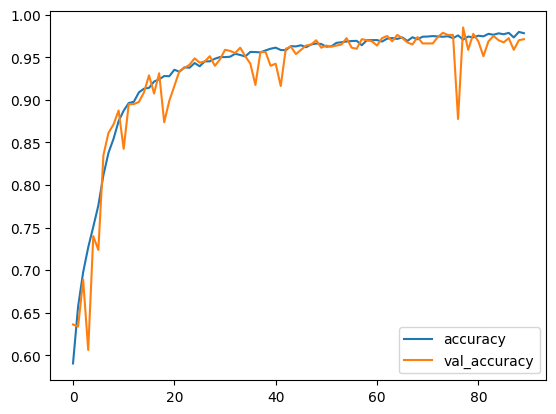

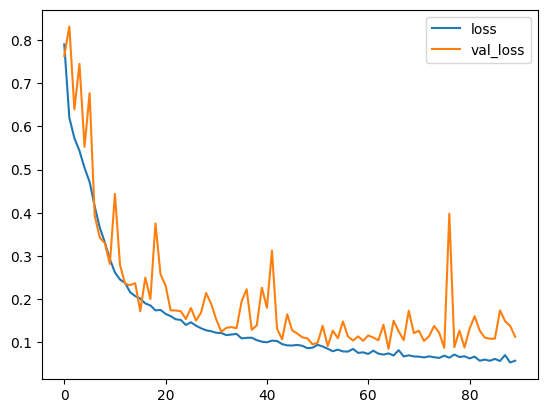

10/10 [==============================] - 2s 163ms/step
[[67 83]
 [82 68]]
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       150
           1       0.45      0.45      0.45       150

    accuracy                           0.45       300
   macro avg       0.45      0.45      0.45       300
weighted avg       0.45      0.45      0.45       300



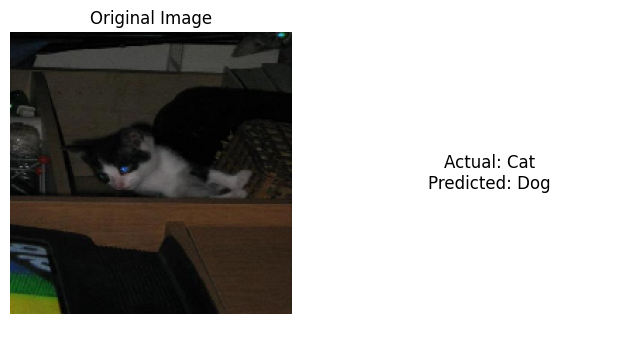

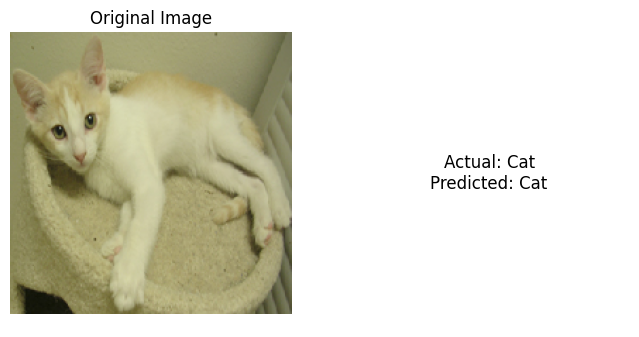

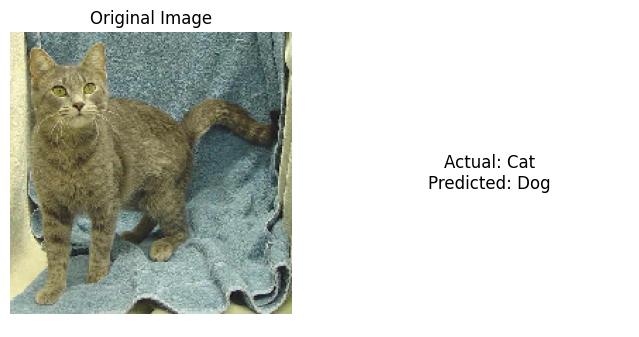

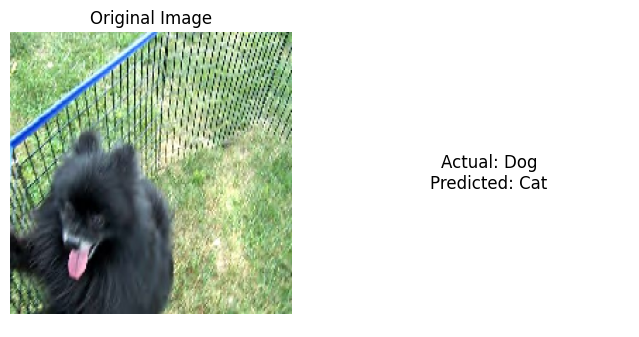

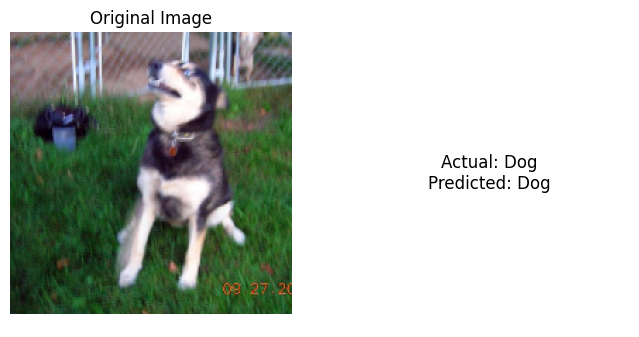

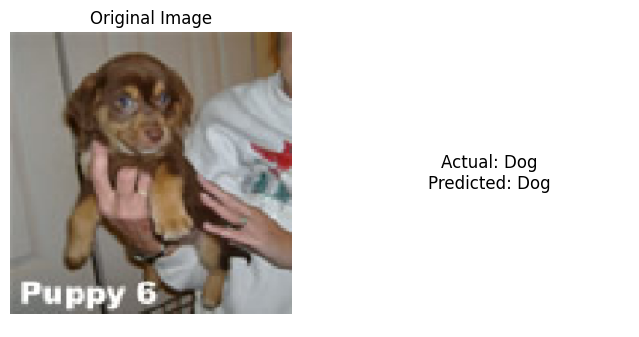

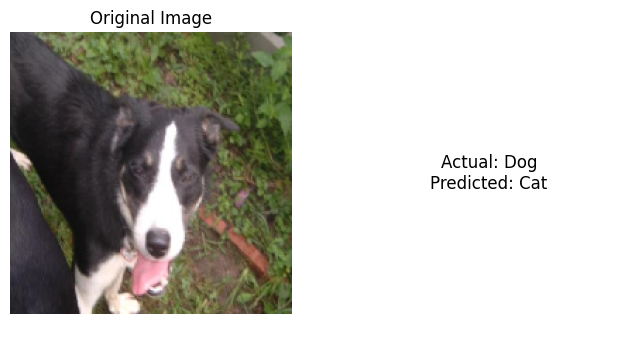

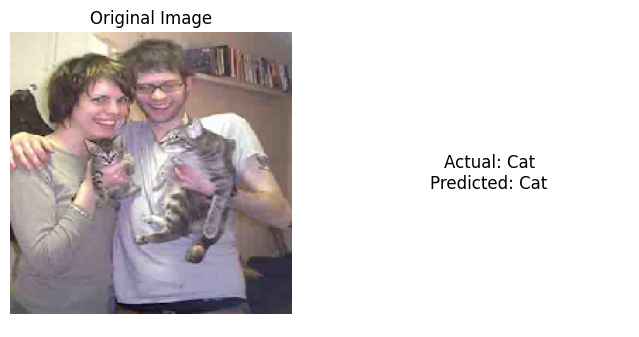

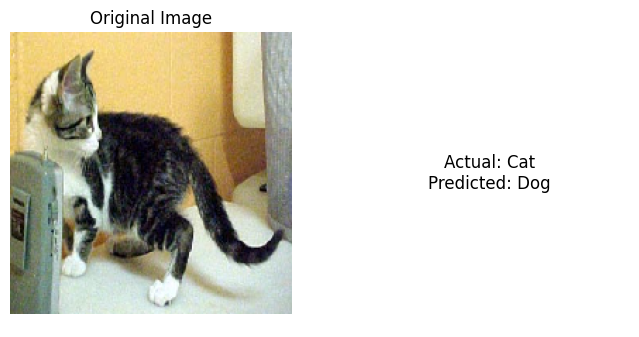

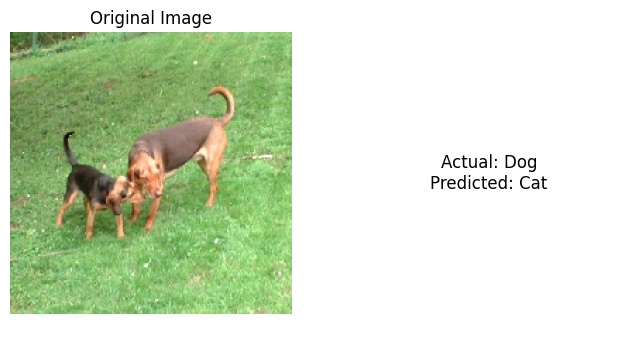

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model
from keras.models import load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, Concatenate,
                                     Activation, ReLU, LeakyReLU)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
from random import sample


from google.colab import drive
drive.mount('/content/gdrive')

# Copying training data
!mkdir -p /content/train/cats
!mkdir -p /content/train/dogs
!cp -r "/content/gdrive/MyDrive/Colab_Notebooks_2/PetImages/train/cats/"* /content/train/cats/
!cp -r "/content/gdrive/MyDrive/Colab_Notebooks_2/PetImages/train/dogs/"* /content/train/dogs/

# Copying test data
!mkdir -p /content/test/cats
!mkdir -p /content/test/dogs
!cp -r "/content/gdrive/MyDrive/Colab_Notebooks_2/PetImages/test/cats/"* /content/test/cats/
!cp -r "/content/gdrive/MyDrive/Colab_Notebooks_2/PetImages/test/dogs/"* /content/test/dogs/

# Creating validation folders and moving 400 random images from test to validation
!mkdir -p /content/validation/cats
!mkdir -p /content/validation/dogs

for animal in ['cats', 'dogs']:
    src_folder = f'/content/test/{animal}/'
    dest_folder = f'/content/validation/{animal}/'

    images = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    for image in sample(images, 400):
        shutil.move(src_folder + image, dest_folder + image)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/validation',
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)

# Counting training instances
train_cats = sum(train_generator.labels == 0)  # Assuming 0 is the label for 'cat'
train_dogs = sum(train_generator.labels == 1)  # Assuming 1 is the label for 'dog'
print(f"Training set has {train_cats} cat images and {train_dogs} dog images.")
# Counting validation instances
val_cats = sum(validation_generator.labels == 0)
val_dogs = sum(validation_generator.labels == 1)
print(f"Validation set has {val_cats} cat images and {val_dogs} dog images.")
# Counting test instances
test_cats = sum(test_generator.labels == 0)
test_dogs = sum(test_generator.labels == 1)
print(f"Test set has {test_cats} cat images and {test_dogs} dog images.")

# Input layer
input_layer = Input(shape=(200, 200, 3))

# First head
x1 = Conv2D(64, (1, 1), kernel_initializer='he_normal', padding='same')(input_layer)
x1 = BatchNormalization()(x1)
x1 = LeakyReLU()(x1)
x1 = MaxPooling2D(2, 2)(x1)
x1 = Dropout(0.2)(x1)
x1 = Conv2D(128, (1, 1), kernel_initializer='he_normal', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = LeakyReLU()(x1)
x1 = MaxPooling2D(2, 2)(x1)
x1 = Dropout(0.2)(x1)

# Second head
x2 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(input_layer)
x2 = BatchNormalization()(x2)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D(2, 2)(x2)
x2 = Dropout(0.2)(x2)
x2 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D(2, 2)(x2)
x2 = Dropout(0.2)(x2)

# Third head
x3 = Conv2D(64, (5, 5), kernel_initializer='he_normal', padding='same')(input_layer)
x3 = BatchNormalization()(x3)
x3 = LeakyReLU()(x3)
x3 = MaxPooling2D(2, 2)(x3)
x3 = Dropout(0.2)(x3)
x3 = Conv2D(128, (5, 5), kernel_initializer='he_normal', padding='same')(x3)
x3 = BatchNormalization()(x3)
x3 = LeakyReLU()(x3)
x3 = MaxPooling2D(2, 2)(x3)
x3 = Dropout(0.2)(x3)

# Fourth head
x4 = Conv2D(64, (7, 7), kernel_initializer='he_normal', padding='same')(input_layer)
x4 = BatchNormalization()(x4)
x4 = LeakyReLU()(x4)
x4 = MaxPooling2D(2, 2)(x4)
x4 = Dropout(0.2)(x4)
x4 = Conv2D(128, (7, 7), kernel_initializer='he_normal', padding='same')(x4)
x4 = BatchNormalization()(x4)
x4 = LeakyReLU()(x4)
x4 = MaxPooling2D(2, 2)(x4)
x4 = Dropout(0.2)(x4)

# Concatenate the output of the four branches
merged = Concatenate()([x1, x2, x3, x4])

x = Conv2D(128, (7, 7), kernel_initializer='he_normal', padding='same')(merged)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(256, (5, 5), kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=25)
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stop]
)

_, acc = model.evaluate(test_generator,
                        steps=len(test_generator),
                        verbose=0)
print('Test Accuracy -> %.3f' % (acc * 100.0))

# Plot loss and accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Initialize empty arrays to store results
all_labels = []
all_predictions = []
all_images = []  # To store some images for later visualization

# Manually loop over the generator and make predictions
for i in range(len(test_generator)):
    images_batch, labels_batch = next(test_generator)
    predictions_batch = model.predict(images_batch)

    # Store some images, labels, and predictions
    all_labels.extend(labels_batch)
    all_predictions.extend(predictions_batch)

    if i == 0:  # Storing only the first batch of images
        all_images.extend(images_batch)

# Convert to NumPy arrays for easier slicing and indexing
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_images = np.array(all_images)  # Convert list of images to NumPy array

# Round predictions to nearest integer (0 or 1) to get the class labels
rounded_predictions = np.round(all_predictions).astype('int').flatten()

# Now your confusion matrix and classification reports will be aligned
print(confusion_matrix(all_labels, rounded_predictions))
print(classification_report(all_labels, rounded_predictions))

# Convert predictions and labels to binary labels (0: Cat, 1: Dog)
rounded_predictions_binary = np.where(all_predictions > 0.5, 1, 0).flatten()
labels_binary = all_labels.astype('int')

# Plot the first 10 images
for i in range(10):
    plt.figure(figsize=(8, 4))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(all_images[i])
    plt.title("Original Image")
    plt.axis('off')

    # Show actual and predicted labels
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f"Actual: {'Dog' if labels_binary[i] else 'Cat'}\nPredicted: {'Dog' if rounded_predictions_binary[i] else 'Cat'}",
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=12)
    plt.axis('off')

    plt.show()



1/1 [==============================] - 0s 42ms/step
[[138   5]
 [  3 154]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       143
         1.0       0.97      0.98      0.97       157

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



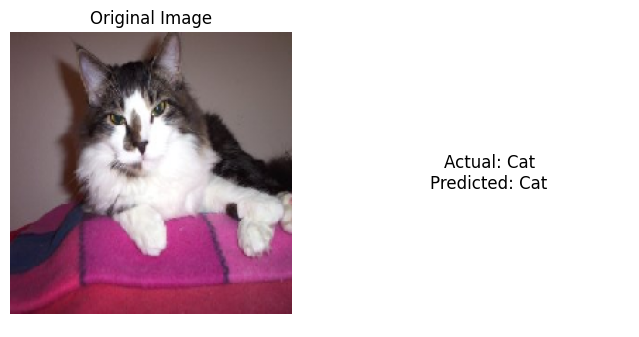

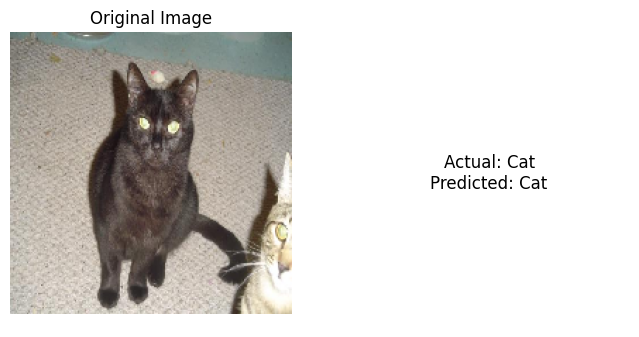

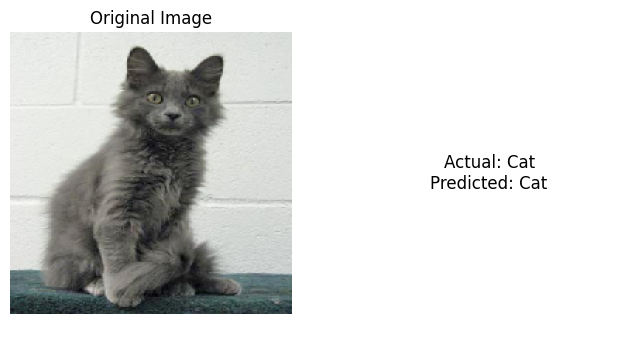

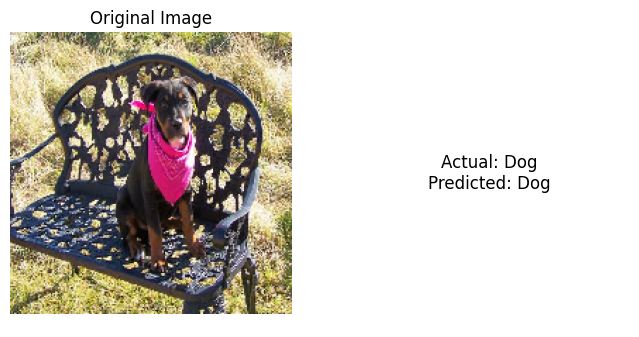

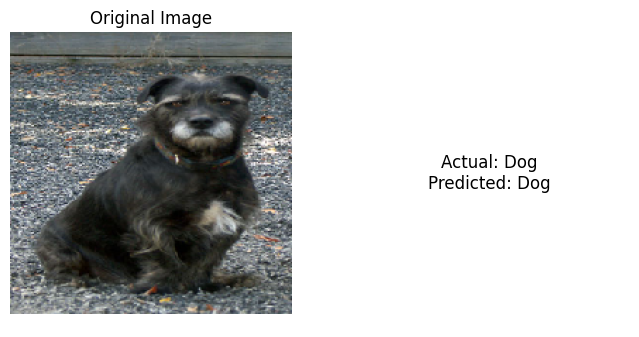

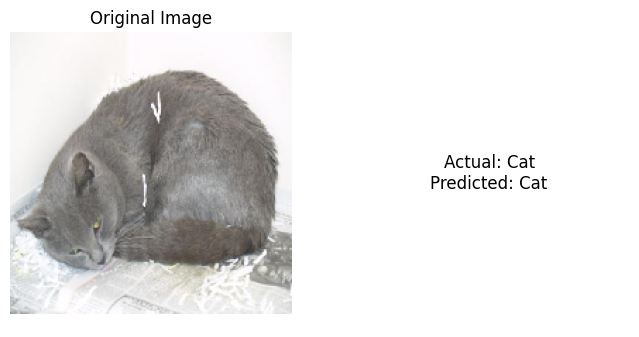

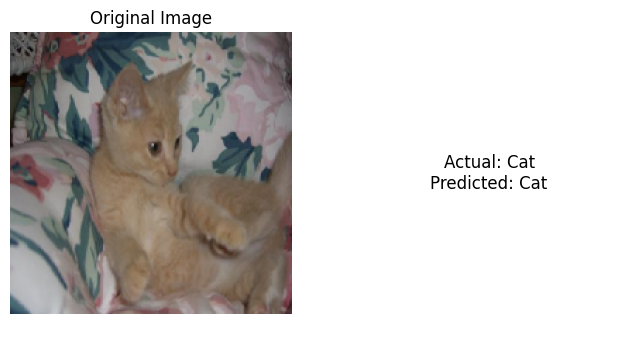

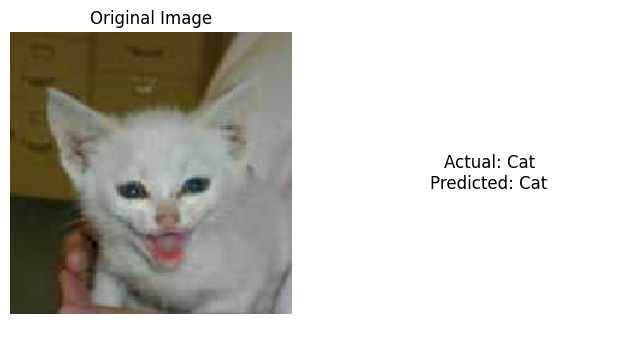

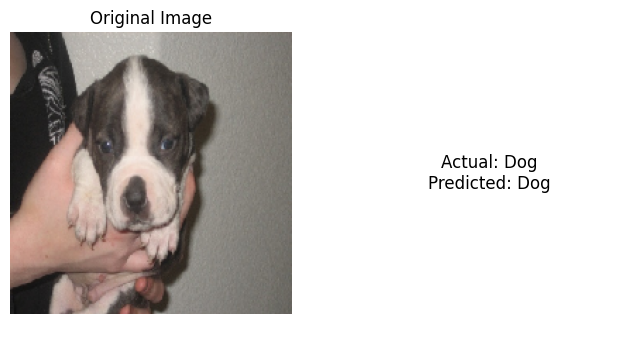

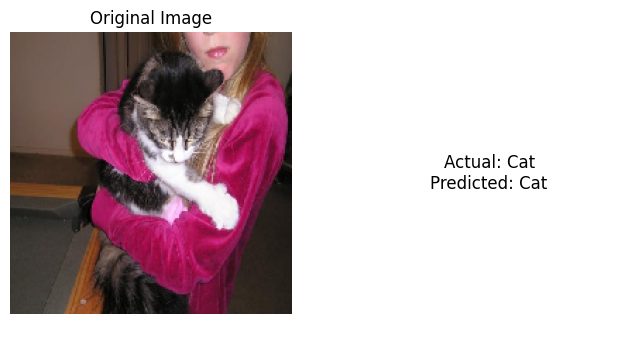

In [ ]:
# Initialize empty arrays to store results
all_labels = []
all_predictions = []
all_images = []  # To store some images for later visualization

# Manually loop over the generator and make predictions
for i in range(len(test_generator)):
    images_batch, labels_batch = next(test_generator)
    predictions_batch = model.predict(images_batch)

    # Store some images, labels, and predictions
    all_labels.extend(labels_batch)
    all_predictions.extend(predictions_batch)

    if i == 0:  # Storing only the first batch of images
        all_images.extend(images_batch)

# Convert to NumPy arrays for easier slicing and indexing
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_images = np.array(all_images)  # Convert list of images to NumPy array

# Round predictions to nearest integer (0 or 1) to get the class labels
rounded_predictions = np.round(all_predictions).astype('int').flatten()

# Now your confusion matrix and classification reports will be aligned
print(confusion_matrix(all_labels, rounded_predictions))
print(classification_report(all_labels, rounded_predictions))

# Convert predictions and labels to binary labels (0: Cat, 1: Dog)
rounded_predictions_binary = np.where(all_predictions > 0.5, 1, 0).flatten()
labels_binary = all_labels.astype('int')

# Plot the first 10 images
for i in range(10):
    plt.figure(figsize=(8, 4))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(all_images[i])
    plt.title("Original Image")
    plt.axis('off')

    # Show actual and predicted labels
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f"Actual: {'Dog' if labels_binary[i] else 'Cat'}\nPredicted: {'Dog' if rounded_predictions_binary[i] else 'Cat'}",
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=12)
    plt.axis('off')

    plt.show()


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = '/content/gdrive/My Drive/Colab_Notebooks_2/cat_pic.jpg'
img = Image.open(img_path)

# Inspect the image
plt.imshow(img)
plt.show()

# Preprocess the image
img = img.resize((200, 200))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

# Run prediction
prediction = model.predict(img_array)

# Interpret the prediction (replace this with your own logic)
print(f"Prediction: {prediction}")